<a href="https://colab.research.google.com/github/shadab4150/NLP-Disaster-tweet-prediction-Socialmedia/blob/master/real_or_not_disaster_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.text import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
path = Path('/content/')
path.ls()

[PosixPath('/content/.config'),
 PosixPath('/content/sample_submission.csv'),
 PosixPath('/content/test.csv'),
 PosixPath('/content/train.csv'),
 PosixPath('/content/sample_data')]

In [0]:
df=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')
sample=pd.read_csv('sample_submission.csv')

In [72]:
df.head()

id keyword  ...                                               text target
0   1     NaN  ...  Our Deeds are the Reason of this #earthquake M...      1
1   4     NaN  ...             Forest fire near La Ronge Sask. Canada      1
2   5     NaN  ...  All residents asked to 'shelter in place' are ...      1
3   6     NaN  ...  13,000 people receive #wildfires evacuation or...      1
4   7     NaN  ...  Just got sent this photo from Ruby #Alaska as ...      1

[5 rows x 5 columns]

In [0]:
df_new=pd.read_csv('/content/socialmedia.csv')
df_new

In [73]:
df_test.head()

id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan

In [19]:
df['text'][13]

'#Flood in Bago Myanmar #We arrived Bago'

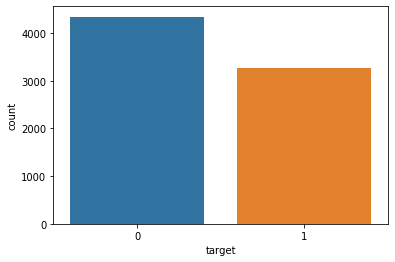

In [18]:
sns.countplot(x='target',data=df)

In [0]:
df.location.fillna(value='unknown',inplace=True)

In [0]:
df_test.location.fillna(value='unknown',inplace=True)

In [0]:
df['text_all']=df['location']+' '+df['text']

In [0]:
df_test['text_all']=df_test['location']+' '+df_test['text']

In [29]:
df_train=df[['text_all','target']].copy()
df_train.head()

text_all  target
0  unknown Our Deeds are the Reason of this #eart...       1
1     unknown Forest fire near La Ronge Sask. Canada       1
2  unknown All residents asked to 'shelter in pla...       1
3  unknown 13,000 people receive #wildfires evacu...       1
4  unknown Just got sent this photo from Ruby #Al...       1

In [47]:
df_train.columns=['text','label']
df_train.head()

text  label
0  unknown Our Deeds are the Reason of this #eart...      1
1     unknown Forest fire near La Ronge Sask. Canada      1
2  unknown All residents asked to 'shelter in pla...      1
3  unknown 13,000 people receive #wildfires evacu...      1
4  unknown Just got sent this photo from Ruby #Al...      1

In [35]:
df_test1=df[['text_all']].copy()
df_test1.head()

text_all
0  unknown Our Deeds are the Reason of this #eart...
1     unknown Forest fire near La Ronge Sask. Canada
2  unknown All residents asked to 'shelter in pla...
3  unknown 13,000 people receive #wildfires evacu...
4  unknown Just got sent this photo from Ruby #Al...

In [0]:
df_train.to_csv('texts.csv',index=False)

In [0]:
df_test1.to_csv('texts_test.csv',index=False)

In [36]:
idcode=df_test.id.values
idcode

array([    0,     2,     3,     9, ..., 10865, 10868, 10874, 10875])

In [0]:
text_columns=['text']
label_columns=['target']
BATCH_SIZE=128

In [55]:
tweets = pd.concat([df[text_columns], df_test[text_columns]])
print(tweets.shape)

(10876, 1)


In [74]:
tweets.head()

text
0  Our Deeds are the Reason of this #earthquake M...
1             Forest fire near La Ronge Sask. Canada
2  All residents asked to 'shelter in place' are ...
3  13,000 people receive #wildfires evacuation or...
4  Just got sent this photo from Ruby #Alaska as ...

In [56]:
data_lm = (TextList.from_df(tweets)
           #Inputs: all the text files in path
            .split_by_rand_pct(0.15)
           #We randomly split and keep 10% for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=BATCH_SIZE))
data_lm.save('tmp_lm')

In [57]:
data_lm.show_batch()

In [58]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

In [59]:
print('Model Summary:')
print(learn.layer_groups)

Model Summary:
[Sequential(
  (0): WeightDropout(
    (module): LSTM(400, 1152, batch_first=True)
  )
  (1): RNNDropout()
), Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 1152, batch_first=True)
  )
  (1): RNNDropout()
), Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 400, batch_first=True)
  )
  (1): RNNDropout()
), Sequential(
  (0): Embedding(5240, 400, padding_idx=1)
  (1): EmbeddingDropout(
    (emb): Embedding(5240, 400, padding_idx=1)
  )
  (2): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=5240, bias=True)
    (output_dp): RNNDropout()
  )
)]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02
Min loss divided by 10: 9.12E-02


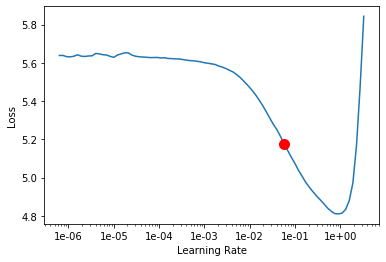

In [60]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [61]:
learn.fit_one_cycle(10, 1e-2)

In [0]:
learn.save('lm_model_tweets')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.32E-03


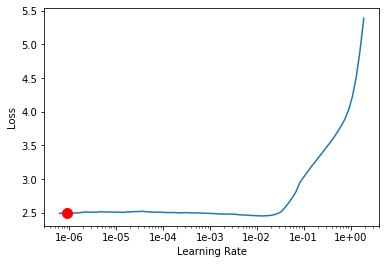

In [63]:
learn.load('lm_model_tweets')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [64]:
learn.fit_one_cycle(10, 1e-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-06
Min loss divided by 10: 8.32E-05


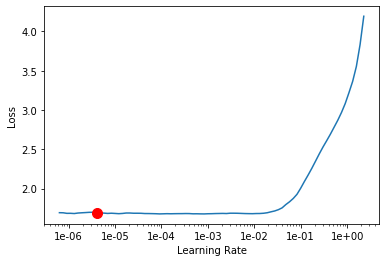

In [67]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [69]:
learn.fit_one_cycle(10, 1e-4)

In [0]:
learn.save_encoder('ft_enc')

In [0]:
learn.save('lm_model_tweets1')

In [76]:
data_clas = (TextList.from_df(df, cols=text_columns, vocab=data_lm.vocab)
             .split_by_rand_pct(0.15)
             .label_from_df('target')
             .add_test(df_test[text_columns])
             .databunch(bs=BATCH_SIZE))

data_clas.save('tmp_clas')

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

In [78]:
learn.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (6472 items)
x: TextList
xxbos xxmaj our xxmaj xxunk are the xxmaj reason of this # earthquake xxmaj may xxup allah xxmaj forgive us all,xxbos xxmaj forest fire near xxmaj la xxmaj xxunk xxmaj xxunk . xxmaj canada,xxbos xxmaj all residents asked to ' shelter in place ' are being xxunk by officers . xxmaj no other evacuation or shelter in place orders are expected,xxbos xxunk people xxunk # wildfires evacuation orders in xxmaj california,xxbos xxmaj just got sent this photo from xxmaj xxunk # xxmaj alaska as smoke from # wildfires xxunk into a school
y: CategoryList
1,1,1,1,1
Path: .;

Valid: LabelList (1141 items)
x: TextList
xxbos xxunk i just screamed to the world how much i love xxmaj my xxmaj little xxmaj xxunk ? ?,xxbos xxmaj the whole food stamp gov . assistance program needs to be xxunk for wounded veterans xxunk and xxunk only . # xxunk,xxbos xxup @potus you until you drown by water xxunk the lungs . xxmaj you being alive has

In [79]:
learn.freeze_to(-1)
learn.summary()

SequentialRNN
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [65, 400]            0          False     
______________________________________________________________________
RNNDropout           [65, 1152]           0          False     
______________________________________________________________________
RNNDropout           [65, 1152]           0          False     
______________________________________________________________________
BatchNorm1d          [1200]               2,400      True      
______________________________________________________________________
Dropout              [1200]               0          False     
______________________________________________________________________
Linear               [50]                 60,050     True      
______________________________________________________________________
ReLU                 [50]                 0          False     
________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.51E-03
Min loss divided by 10: 5.25E-02


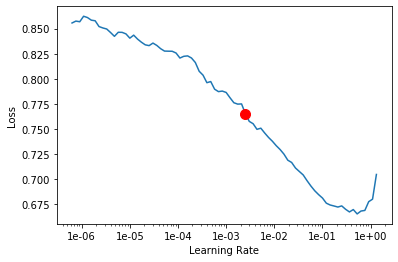

In [80]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [81]:
learn.fit_one_cycle(10, 1e-3)

In [0]:
learn.save('stage1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.10E-07


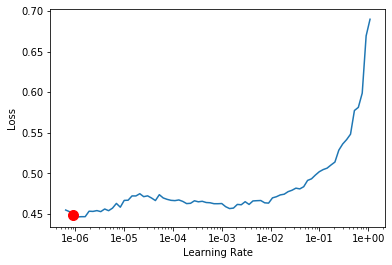

In [83]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [84]:
learn.load('stage1')
learn.freeze_to(-2)
learn.fit_one_cycle(5, slice(5e-3/2., 5e-3))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06
Min loss divided by 10: 1.58E-03


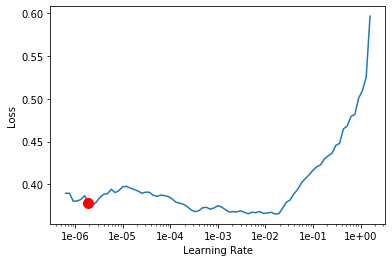

In [85]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.save('stage2')

In [88]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-5,1e-3))

# Final classifier accuracy is 80.3681%

In [0]:
learn.save('stage3')

In [0]:
learn.export()
learn.save('final')

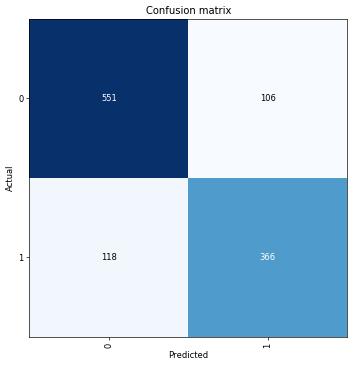

In [91]:
from fastai.vision import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [92]:
interp = TextClassificationInterpretation.from_learner(learn)
interp.show_top_losses(10)

In [93]:
learn.predict(df_test.loc[4,'text'])

(Category 1, tensor(1), tensor([0.0016, 0.9984]))

In [0]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learn.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in learn.data.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

In [95]:
test_preds = get_preds_as_nparray(DatasetType.Test)

In [0]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['target'] = np.argmax(test_preds, axis=1)
sample_submission.to_csv("predictions.csv", index=False, header=True)

# Mounting drive and saving the trained model

In [101]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install -U -q PyDrive

from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile
import os
import sys

zipname = 'model_nlp'

def zipfolder(foldername, target_dir):            
    zipobj = zipfile.ZipFile(foldername + '.zip', 'w', zipfile.ZIP_DEFLATED)
    rootlen = len(target_dir) + 1
    for base, dirs, files in os.walk(target_dir):
        for file in files:
            fn = os.path.join(base, file)
            zipobj.write(fn, fn[rootlen:])

In [0]:
zipfolder(zipname, '/content/MODEL/')

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file1 = drive.CreateFile()
file1.SetContentFile(zipname1+".zip")
file1.Upload()